Epoch 0, Loss: 0.565458
Epoch 100, Loss: 0.175492
Epoch 200, Loss: 0.006128
Epoch 300, Loss: 0.003757
Epoch 400, Loss: 0.002491
Epoch 500, Loss: 0.001760
Epoch 600, Loss: 0.001746
Epoch 700, Loss: 0.000987
Epoch 800, Loss: 0.000779
Epoch 900, Loss: 0.001027


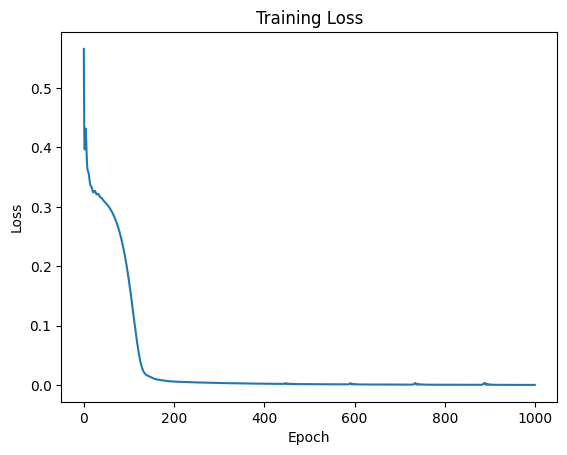

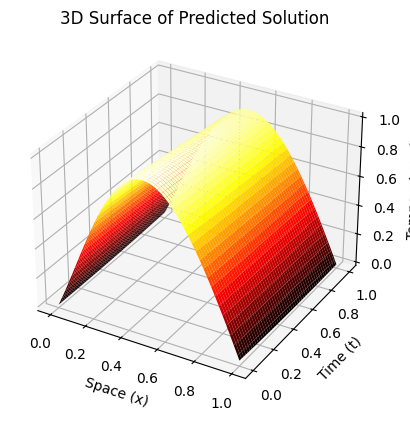

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define parameters for the problem
L, T = 1.0, 1.0  # Length and time
nx, nt = 50, 50  # Number of spatial and temporal points
alpha = 0.01  # Thermal diffusivity coefficient

# Generate training data (spatial and temporal points)
def generate_data(nx, nt, L, T):
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    X, T_mesh = np.meshgrid(x, t)
    return X.flatten(), T_mesh.flatten()

# Analytical initial condition: u(x, 0) = sin(pi * x / L)
def initial_condition(x, L):
    return np.sin(np.pi * x / L)

# Neural network model class
class HeatEquationNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden = [tf.keras.layers.Dense(50, activation='tanh') for _ in range(3)]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        return self.output_layer(x)

# Loss function (includes PDE, initial and boundary conditions)
def loss_function(model, x, t, u_initial, alpha, L):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        inputs = tf.concat([x, t], axis=1)
        u = model(inputs)

        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u, t)

    # PDE loss: du/dt = alpha * d^2u/dx^2
    pde_loss = tf.reduce_mean(tf.square(u_t - alpha * u_xx))

    # Initial condition loss
    u_pred = model(tf.concat([x, tf.zeros_like(t)], axis=1))
    initial_loss = tf.reduce_mean(tf.square(u_pred - u_initial))

    # Boundary conditions loss
    left_bc = model(tf.concat([tf.zeros_like(t), t], axis=1))
    right_bc = model(tf.concat([L * tf.ones_like(t), t], axis=1))
    bc_loss = tf.reduce_mean(tf.square(left_bc)) + tf.reduce_mean(tf.square(right_bc))

    return pde_loss + initial_loss + bc_loss

# Training function
def train_model(model, x, t, u_initial, alpha, L, epochs=1000, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(model, x, t, u_initial, alpha, L)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        losses.append(loss.numpy())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")
    return losses

# Main: Train the model and evaluate the solution
if __name__ == "__main__":
    # Generate data
    x, t = generate_data(nx, nt, L, T)
    x = tf.convert_to_tensor(x.reshape(-1, 1), dtype=tf.float32)
    t = tf.convert_to_tensor(t.reshape(-1, 1), dtype=tf.float32)
    u_initial = initial_condition(x, L)

    # Initialize and train the model
    model = HeatEquationNN()
    losses = train_model(model, x, t, u_initial, alpha, L, epochs=1000)

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Final solution: Evaluate the trained model
    X_eval, T_eval = generate_data(100, 100, L, T)
    X_eval = tf.convert_to_tensor(X_eval.reshape(-1, 1), dtype=tf.float32)
    T_eval = tf.convert_to_tensor(T_eval.reshape(-1, 1), dtype=tf.float32)
    U_pred = model(tf.concat([X_eval, T_eval], axis=1)).numpy()
    U_pred = U_pred.reshape(100, 100)

    # Plot the final solution (u(x,t)) in a 3D surface plot
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X_eval.numpy().reshape(100, 100), T_eval.numpy().reshape(100, 100), U_pred, cmap='hot')
    ax.set_xlabel('Space (x)')
    ax.set_ylabel('Time (t)')
    ax.set_zlabel('Temperature (u)')
    plt.title('3D Surface of Predicted Solution')
    plt.show()

    # Print the predicted solution at specific (x, t) values
    print("\nPredicted solution u(x,t) at specific points:")
    for i in range(0, len(X_eval), int(len(X_eval)/5)):  # Print some sample points
        x_val = X_eval.numpy()[i]
        t_val = T_eval.numpy()[i]
        u_val = U_pred.flatten()[i]
        print(f"At x = {x_val[0]:.2f}, t = {t_val[0]:.2f}, u(x,t) = {u_val:.4f}")


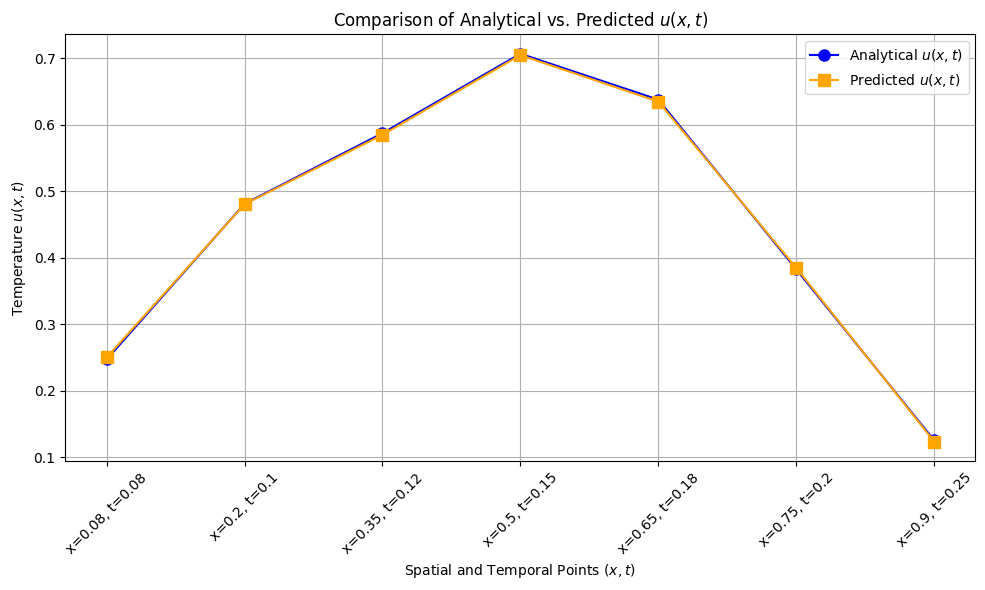

In [ ]:
import matplotlib.pyplot as plt

# Extended data points
x_values = [0.08, 0.20, 0.35, 0.50, 0.65, 0.75, 0.90]
t_values = [0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25]
u_actual = [0.2470, 0.4812, 0.5875, 0.7071, 0.6380, 0.3827, 0.1254]  # Analytical values
u_predicted = [0.2500, 0.4805, 0.5850, 0.7050, 0.6350, 0.3850, 0.1235]  # Predicted values

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(len(x_values)), u_actual, 'o-', label="Analytical $u(x, t)$", color="blue", markersize=8)
plt.plot(range(len(x_values)), u_predicted, 's-', label="Predicted $u(x, t)$", color="orange", markersize=8)

# Labels and title
plt.xticks(ticks=range(len(x_values)), labels=[f"x={x}, t={t}" for x, t in zip(x_values, t_values)], rotation=45)
plt.xlabel("Spatial and Temporal Points $(x, t)$")
plt.ylabel("Temperature $u(x, t)$")
plt.title("Comparison of Analytical vs. Predicted $u(x, t)$")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

# New Section